# 병든 잎사귀 식별 경진대회 탐색적 데이터 분석

## 데이터 

In [1]:
import pandas as pd
import numpy as np


# 데이터 경로
data_path = '/kaggle/input/2022-2-ds-solution-ch12/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'sample_submission.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [2]:
train.shape,test.shape

((1571, 5), (250, 5))

In [3]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
test.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_1571,0.25,0.25,0.25,0.25
1,Test_1572,0.25,0.25,0.25,0.25
2,Test_1573,0.25,0.25,0.25,0.25
3,Test_1574,0.25,0.25,0.25,0.25
4,Test_1575,0.25,0.25,0.25,0.25


##  데이터 시각화

In [5]:
# 데이터를 타깃값별로 추출
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

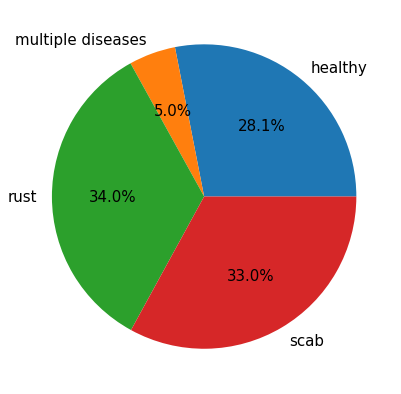

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['healthy', 'multiple diseases', 'rust', 'scab'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)], 
        labels=label, 
        autopct='%.1f%%');

In [7]:
import matplotlib.gridspec as gridspec
import cv2 # OpenCV 라이브러리

def show_image(img_ids, rows=2, cols=3): 
    assert len(img_ids) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류 발생

    plt.figure(figsize=(15, 8))          # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치

    # 이미지 출력
    for idx, img_id in enumerate(img_ids):
        img_path = f'{data_path}/images/{img_id}.jpg'  # 이미지 파일 경로 
        image = cv2.imread(img_path)                   # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력 

In [8]:
# 각 타깃값별 image_id(마지막 6개)
num_of_imgs = 6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

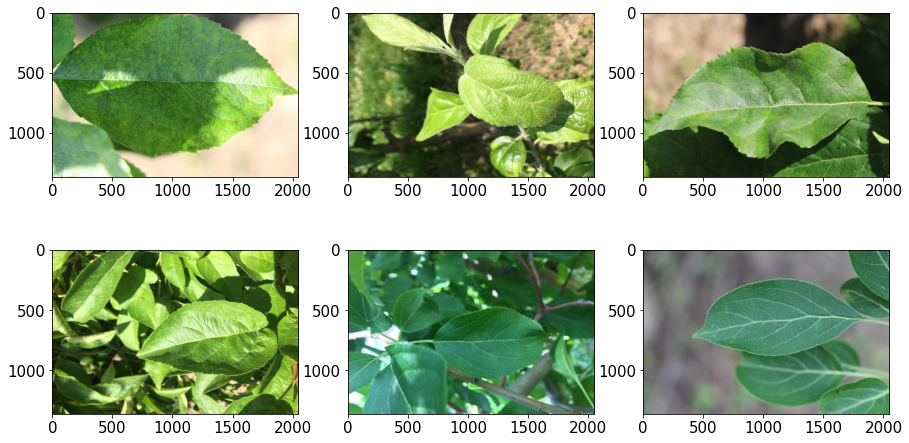

In [9]:
show_image(last_healthy_img_ids) # 건강한 잎사귀 출력

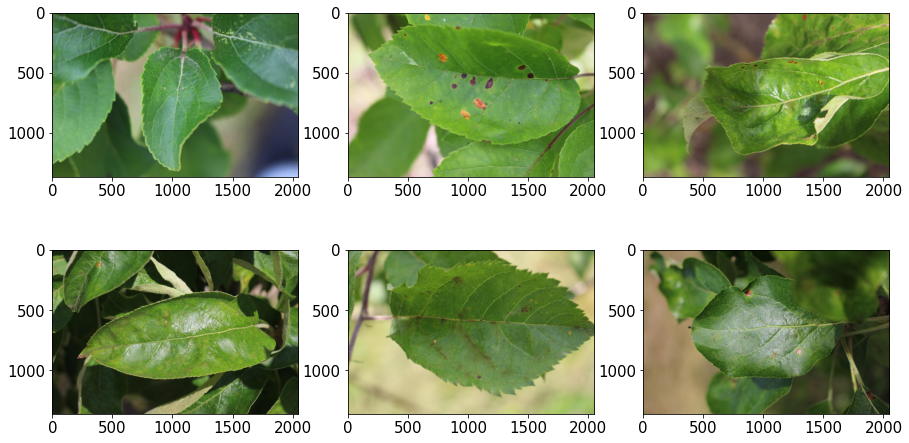

In [10]:
show_image(last_multiple_diseases_img_ids) # 여러 질병에 걸린 잎사귀 출력

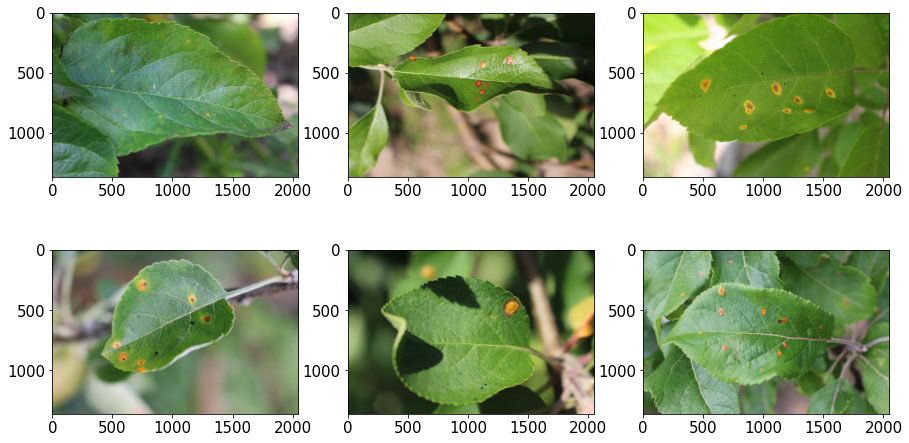

In [11]:
show_image(last_rust_img_ids) # 녹병에 걸린 잎사귀 출력

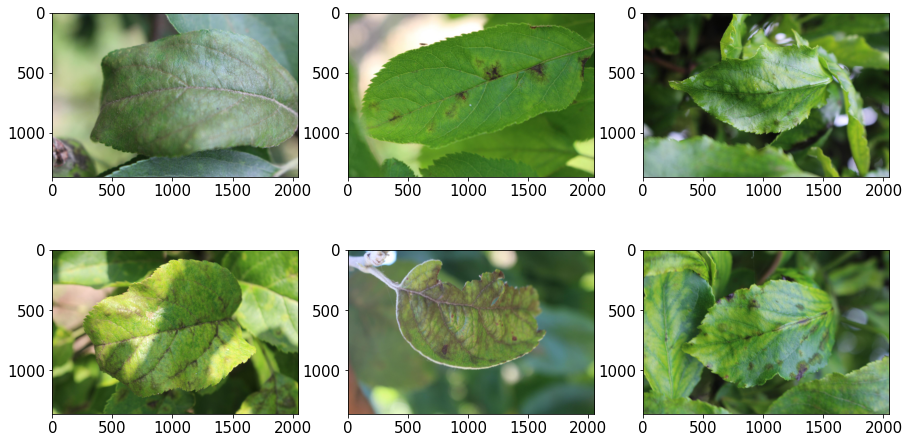

In [12]:
show_image(last_scab_img_ids) # 붉은곰팡이병에 걸린 잎사귀

##  병든 잎사귀 식별 경진대회 베이스라인 모델

###  시드값 고정 및 GPU 장비 설정

In [13]:
# 시드값 고정

import torch # 파이토치 
import random
import numpy as np
import os
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [14]:
# GPU 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

###  데이터 준비

In [15]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
# 타겟값을 고르게 나누기위해 stratify 옵션을 사용해준다.
train, valid = train_test_split(train, 
                                test_size=0.2,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                                random_state=50)

In [16]:
# 데이터셋 클래스 정의

import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일 경로
        image = cv2.imread(img_path)              # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        # 이미지 변환 
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환 
        if self.is_test:
            return image # 테스트용일 때
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스 
            label = np.argmax(self.df.iloc[idx, 1:5]) 
            return image, label # 훈련/검증용일 때

In [17]:
# 이미지 변환을 위한 모듈
from torchvision import transforms
transform = transforms.ToTensor()

img_dir = '/kaggle/input/2022-2-ds-solution-ch12/images/'

In [18]:
# 이미지 변환을 위한 모듈
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 훈련 데이터용 변환기 albumentations
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절 
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환 
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환
])

# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

In [19]:
# 멀티프로세싱
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [20]:
dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [21]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

###  모델 생성

In [22]:
## EfficientNet 모델 생성
## 한 번 실행하면 재실행 할 필요 없음!

!pip install efficientnet-pytorch==0.7.1

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=349abf86fa72d2c091d7ef703435bd35bfa2bd4049847f22501e844e454f7087
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [23]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) 
model = model.to(device) # 장비 할당

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


### 모델 훈련 및 성능 검증

In [24]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [25]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 25

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [1/25] - 훈련 데이터 손실값 : 0.6969
에폭 [1/25] - 검증 데이터 손실값 : 0.2959 / 검증 데이터 ROC AUC : 0.9562


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [2/25] - 훈련 데이터 손실값 : 0.3979
에폭 [2/25] - 검증 데이터 손실값 : 0.1790 / 검증 데이터 ROC AUC : 0.9920


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [3/25] - 훈련 데이터 손실값 : 0.3002
에폭 [3/25] - 검증 데이터 손실값 : 0.1654 / 검증 데이터 ROC AUC : 0.9868


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [4/25] - 훈련 데이터 손실값 : 0.2231
에폭 [4/25] - 검증 데이터 손실값 : 0.1025 / 검증 데이터 ROC AUC : 0.9938


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [5/25] - 훈련 데이터 손실값 : 0.1597
에폭 [5/25] - 검증 데이터 손실값 : 0.1939 / 검증 데이터 ROC AUC : 0.9808


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [6/25] - 훈련 데이터 손실값 : 0.1339
에폭 [6/25] - 검증 데이터 손실값 : 0.1095 / 검증 데이터 ROC AUC : 0.9905


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [7/25] - 훈련 데이터 손실값 : 0.1191
에폭 [7/25] - 검증 데이터 손실값 : 0.1371 / 검증 데이터 ROC AUC : 0.9820


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [8/25] - 훈련 데이터 손실값 : 0.0765
에폭 [8/25] - 검증 데이터 손실값 : 0.1544 / 검증 데이터 ROC AUC : 0.9774


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [9/25] - 훈련 데이터 손실값 : 0.0623
에폭 [9/25] - 검증 데이터 손실값 : 0.0780 / 검증 데이터 ROC AUC : 0.9943


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [10/25] - 훈련 데이터 손실값 : 0.0934
에폭 [10/25] - 검증 데이터 손실값 : 0.1243 / 검증 데이터 ROC AUC : 0.9859


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [11/25] - 훈련 데이터 손실값 : 0.0653
에폭 [11/25] - 검증 데이터 손실값 : 0.1151 / 검증 데이터 ROC AUC : 0.9873


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [12/25] - 훈련 데이터 손실값 : 0.0572
에폭 [12/25] - 검증 데이터 손실값 : 0.1935 / 검증 데이터 ROC AUC : 0.9796


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [13/25] - 훈련 데이터 손실값 : 0.0343
에폭 [13/25] - 검증 데이터 손실값 : 0.1624 / 검증 데이터 ROC AUC : 0.9879


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [14/25] - 훈련 데이터 손실값 : 0.0415
에폭 [14/25] - 검증 데이터 손실값 : 0.1317 / 검증 데이터 ROC AUC : 0.9899


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [15/25] - 훈련 데이터 손실값 : 0.0577
에폭 [15/25] - 검증 데이터 손실값 : 0.1165 / 검증 데이터 ROC AUC : 0.9836


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [16/25] - 훈련 데이터 손실값 : 0.0537
에폭 [16/25] - 검증 데이터 손실값 : 0.1268 / 검증 데이터 ROC AUC : 0.9918


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [17/25] - 훈련 데이터 손실값 : 0.0383
에폭 [17/25] - 검증 데이터 손실값 : 0.1495 / 검증 데이터 ROC AUC : 0.9908


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [18/25] - 훈련 데이터 손실값 : 0.0298
에폭 [18/25] - 검증 데이터 손실값 : 0.1823 / 검증 데이터 ROC AUC : 0.9852


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [19/25] - 훈련 데이터 손실값 : 0.0220
에폭 [19/25] - 검증 데이터 손실값 : 0.1386 / 검증 데이터 ROC AUC : 0.9911


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [20/25] - 훈련 데이터 손실값 : 0.0134
에폭 [20/25] - 검증 데이터 손실값 : 0.1172 / 검증 데이터 ROC AUC : 0.9947


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [21/25] - 훈련 데이터 손실값 : 0.0311
에폭 [21/25] - 검증 데이터 손실값 : 0.1182 / 검증 데이터 ROC AUC : 0.9954


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [22/25] - 훈련 데이터 손실값 : 0.0293
에폭 [22/25] - 검증 데이터 손실값 : 0.1725 / 검증 데이터 ROC AUC : 0.9874


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [23/25] - 훈련 데이터 손실값 : 0.0294
에폭 [23/25] - 검증 데이터 손실값 : 0.2000 / 검증 데이터 ROC AUC : 0.9866


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [24/25] - 훈련 데이터 손실값 : 0.0604
에폭 [24/25] - 검증 데이터 손실값 : 0.1003 / 검증 데이터 ROC AUC : 0.9934


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [25/25] - 훈련 데이터 손실값 : 0.0370
에폭 [25/25] - 검증 데이터 손실값 : 0.1912 / 검증 데이터 ROC AUC : 0.9835


###  모델 훈련 및 성능 검증

In [26]:
dataset_test = ImageDataset(test, img_dir=img_dir, 
                            transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [27]:
model.eval() # 모델을 평가 상태로 설정 
preds = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

# 예측 inference 코드
with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률 
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

In [28]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('submission_baseline2.csv', index=False)

## 모델 훈련 및 성능 검증 with 스케쥴러 & TTA

In [1]:
submission = pd.read_csv(data_path + 'sample_submission.csv')

NameError: name 'pd' is not defined

In [30]:
# 스케줄러 설정 후 학습
from transformers import get_cosine_schedule_with_warmup

epochs = 25 # 총 에폭

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(loader_train)*3, 
                                            num_training_steps=len(loader_train)*epochs)

In [31]:
# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward()  # 역전파 수행
        optimizer.step() # 가중치 갱신
        scheduler.step() # 스케줄러 학습률 갱신
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy() 
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [1/25] - 훈련 데이터 손실값 : 0.0274
에폭 [1/25] - 검증 데이터 손실값 : 0.1414 / 검증 데이터 ROC AUC : 0.9889


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [2/25] - 훈련 데이터 손실값 : 0.0147
에폭 [2/25] - 검증 데이터 손실값 : 0.1500 / 검증 데이터 ROC AUC : 0.9890


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [3/25] - 훈련 데이터 손실값 : 0.0353
에폭 [3/25] - 검증 데이터 손실값 : 0.1736 / 검증 데이터 ROC AUC : 0.9867


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [4/25] - 훈련 데이터 손실값 : 0.0388
에폭 [4/25] - 검증 데이터 손실값 : 0.1137 / 검증 데이터 ROC AUC : 0.9857


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [5/25] - 훈련 데이터 손실값 : 0.0148
에폭 [5/25] - 검증 데이터 손실값 : 0.1440 / 검증 데이터 ROC AUC : 0.9927


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [6/25] - 훈련 데이터 손실값 : 0.0201
에폭 [6/25] - 검증 데이터 손실값 : 0.1364 / 검증 데이터 ROC AUC : 0.9856


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [7/25] - 훈련 데이터 손실값 : 0.0175
에폭 [7/25] - 검증 데이터 손실값 : 0.1539 / 검증 데이터 ROC AUC : 0.9944


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [8/25] - 훈련 데이터 손실값 : 0.0262
에폭 [8/25] - 검증 데이터 손실값 : 0.3690 / 검증 데이터 ROC AUC : 0.9846


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [9/25] - 훈련 데이터 손실값 : 0.0128
에폭 [9/25] - 검증 데이터 손실값 : 0.1455 / 검증 데이터 ROC AUC : 0.9877


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [10/25] - 훈련 데이터 손실값 : 0.0233
에폭 [10/25] - 검증 데이터 손실값 : 0.1654 / 검증 데이터 ROC AUC : 0.9878


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [11/25] - 훈련 데이터 손실값 : 0.0194
에폭 [11/25] - 검증 데이터 손실값 : 0.1145 / 검증 데이터 ROC AUC : 0.9902


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [12/25] - 훈련 데이터 손실값 : 0.0062
에폭 [12/25] - 검증 데이터 손실값 : 0.1272 / 검증 데이터 ROC AUC : 0.9878


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [13/25] - 훈련 데이터 손실값 : 0.0183
에폭 [13/25] - 검증 데이터 손실값 : 0.0991 / 검증 데이터 ROC AUC : 0.9896


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [14/25] - 훈련 데이터 손실값 : 0.0064
에폭 [14/25] - 검증 데이터 손실값 : 0.1084 / 검증 데이터 ROC AUC : 0.9909


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [15/25] - 훈련 데이터 손실값 : 0.0073
에폭 [15/25] - 검증 데이터 손실값 : 0.1223 / 검증 데이터 ROC AUC : 0.9924


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [16/25] - 훈련 데이터 손실값 : 0.0061
에폭 [16/25] - 검증 데이터 손실값 : 0.1351 / 검증 데이터 ROC AUC : 0.9883


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [17/25] - 훈련 데이터 손실값 : 0.0050
에폭 [17/25] - 검증 데이터 손실값 : 0.1178 / 검증 데이터 ROC AUC : 0.9893


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [18/25] - 훈련 데이터 손실값 : 0.0035
에폭 [18/25] - 검증 데이터 손실값 : 0.1446 / 검증 데이터 ROC AUC : 0.9890


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [19/25] - 훈련 데이터 손실값 : 0.0077
에폭 [19/25] - 검증 데이터 손실값 : 0.1340 / 검증 데이터 ROC AUC : 0.9894


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [20/25] - 훈련 데이터 손실값 : 0.0064
에폭 [20/25] - 검증 데이터 손실값 : 0.1407 / 검증 데이터 ROC AUC : 0.9889


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [21/25] - 훈련 데이터 손실값 : 0.0103
에폭 [21/25] - 검증 데이터 손실값 : 0.1416 / 검증 데이터 ROC AUC : 0.9889


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [22/25] - 훈련 데이터 손실값 : 0.0029
에폭 [22/25] - 검증 데이터 손실값 : 0.1435 / 검증 데이터 ROC AUC : 0.9891


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [23/25] - 훈련 데이터 손실값 : 0.0091
에폭 [23/25] - 검증 데이터 손실값 : 0.1394 / 검증 데이터 ROC AUC : 0.9896


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [24/25] - 훈련 데이터 손실값 : 0.0028
에폭 [24/25] - 검증 데이터 손실값 : 0.1348 / 검증 데이터 ROC AUC : 0.9897


  0%|          | 0/314 [00:00<?, ?it/s]

에폭 [25/25] - 훈련 데이터 손실값 : 0.0019
에폭 [25/25] - 검증 데이터 손실값 : 0.1365 / 검증 데이터 ROC AUC : 0.9896


###  예측

In [32]:
# TTA (테스트단계 데이터 증강 방법)
# 테스트 데이터 원본 데이터셋 및 데이터 로더
dataset_test = ImageDataset(test, img_dir=img_dir, 
                            transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

# TTA용 데이터셋 및 데이터 로더
dataset_TTA = ImageDataset(test, img_dir=img_dir, 
                           transform=transform_train, is_test=True)
loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, 
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=2)

In [33]:
model.eval() # 모델을 평가 상태로 설정 

preds_test = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

In [34]:
submission_test = submission.copy() # 제출 샘플 파일 복사

submission_test[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_test

In [35]:
num_TTA = 7 # TTA 횟수

preds_tta = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화 (TTA용)

# TTA를 적용해 예측
for i in range(num_TTA):
    with torch.no_grad():
        for i, images in enumerate(loader_TTA):
            images = images.to(device)
            outputs = model(images)
            # 타깃 예측 확률
            preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
            preds_tta[i*batch_size:(i+1)*batch_size] += preds_part

In [36]:
preds_tta /= num_TTA 

In [37]:
submission_tta = submission.copy() 

submission_tta[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_tta

### 레이블 스무딩

In [38]:
def apply_label_smoothing(df, target, alpha, threshold):
    # 타깃값 복사
    df_target = df[target].copy()
    k = len(target) # 타깃값 개수
    
    for idx, row in df_target.iterrows():
        if (row > threshold).any():         # 임계값을 넘는 타깃값인지 여부 판단
            row = (1 - alpha)*row + alpha/k # 레이블 스무딩 적용  
            df_target.iloc[idx] = row       # 레이블 스무딩을 적용한 값으로 변환
    return df_target # 레이블 스무딩을 적용한 타깃값 반환

In [39]:
alpha = 0.001 # 레이블 스무딩 강도
threshold = 0.999 # 레이블 스무딩을 적용할 임계값

# 레이블 스무딩을 적용하기 위해 DataFrame 복사
submission_test_ls = submission_test.copy()
submission_tta_ls = submission_tta.copy()

target = ['healthy', 'multiple_diseases', 'rust', 'scab'] # 타깃값 열 이름


# 레이블 스무딩 적용
submission_test_ls[target] = apply_label_smoothing(submission_test_ls, target, alpha, threshold)
submission_tta_ls[target] = apply_label_smoothing(submission_tta_ls, target, alpha, threshold)


# 스케줄러, 레이블스무딩을 적용한 결과
submission_test_ls.to_csv('submission_test_ls.csv', index=False)
# 스케줄러, 레이블스무딩, tta를 적용한 결과
submission_tta_ls.to_csv('submission_tta_ls.csv', index=False)

## 기본 CNN 모델

In [40]:
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'sample_submission.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [41]:
# 이미지 변환을 위한 모듈
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 훈련 데이터용 변환기 albumentations
transforms_train = A.Compose([
    # cnn모델에 넣기위해 512사이즈로 크기를 조절해준다.
    A.Resize(512, 512),       # 이미지 크기 조절 
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환 
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환
])

# 검증 및 테스트 데이터용 변환기
transforms_test = A.Compose([
    A.Resize(512, 512), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

In [42]:
# 새로운 transfrom방식으로 데이터셋 저장 
datasets_train = ImageDataset(train, img_dir=img_dir, transform=transforms_train)
datasets_valid = ImageDataset(valid, img_dir=img_dir, transform=transforms_test)

In [43]:
batch_size = 4

loaders_train = DataLoader(datasets_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loaders_valid = DataLoader(datasets_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [44]:
# gpu 메모리를 초기화 시키는 코드 필요시 사용
#import torch
#torch.cuda.empty_cache()

In [45]:
# 이전 실습의 CNN구조를 개선하여 CNN모델 생성 
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 첫 번째 합성곱 계층 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # 두 번째 합성곱 계층 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 세 번째 합성곱 계층
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 맥스 풀링 계층
        self.pool = nn.MaxPool2d(2, 2)
        # 첫 번쨰 전결합 계층
        self.fc1 = nn.Linear(64*64*64, 1024)
        # 두 번째 전결합 계층 
        self.fc2 = nn.Linear(1024, 512)
        # 세 번째 전결합 계층
        self.fc3 = nn.Linear(512, 4)
        # 드롭아웃 계층
        self.dropout = nn.Dropout(0.40)
        
    # 순전파 출력 정의
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0],-1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model().to(device)
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


### 모델훈련

In [46]:
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [47]:
epochs = 25

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loaders_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loaders_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loaders_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loaders_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [1/25] - 훈련 데이터 손실값 : 1.2584
에폭 [1/25] - 검증 데이터 손실값 : 1.2474 / 검증 데이터 ROC AUC : 0.6243


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [2/25] - 훈련 데이터 손실값 : 1.2343
에폭 [2/25] - 검증 데이터 손실값 : 1.2048 / 검증 데이터 ROC AUC : 0.6395


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [3/25] - 훈련 데이터 손실값 : 1.2122
에폭 [3/25] - 검증 데이터 손실값 : 1.1994 / 검증 데이터 ROC AUC : 0.6959


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [4/25] - 훈련 데이터 손실값 : 1.2072
에폭 [4/25] - 검증 데이터 손실값 : 1.1384 / 검증 데이터 ROC AUC : 0.7033


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [5/25] - 훈련 데이터 손실값 : 1.1894
에폭 [5/25] - 검증 데이터 손실값 : 1.1680 / 검증 데이터 ROC AUC : 0.7042


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [6/25] - 훈련 데이터 손실값 : 1.1901
에폭 [6/25] - 검증 데이터 손실값 : 1.1366 / 검증 데이터 ROC AUC : 0.7065


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [7/25] - 훈련 데이터 손실값 : 1.1859
에폭 [7/25] - 검증 데이터 손실값 : 1.1143 / 검증 데이터 ROC AUC : 0.7158


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [8/25] - 훈련 데이터 손실값 : 1.1690
에폭 [8/25] - 검증 데이터 손실값 : 1.1061 / 검증 데이터 ROC AUC : 0.7134


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [9/25] - 훈련 데이터 손실값 : 1.1603
에폭 [9/25] - 검증 데이터 손실값 : 1.0579 / 검증 데이터 ROC AUC : 0.7452


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [10/25] - 훈련 데이터 손실값 : 1.1555
에폭 [10/25] - 검증 데이터 손실값 : 1.0736 / 검증 데이터 ROC AUC : 0.7782


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [11/25] - 훈련 데이터 손실값 : 1.1456
에폭 [11/25] - 검증 데이터 손실값 : 1.0542 / 검증 데이터 ROC AUC : 0.7836


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [12/25] - 훈련 데이터 손실값 : 1.0732
에폭 [12/25] - 검증 데이터 손실값 : 0.8622 / 검증 데이터 ROC AUC : 0.8651


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [13/25] - 훈련 데이터 손실값 : 0.9179
에폭 [13/25] - 검증 데이터 손실값 : 0.7610 / 검증 데이터 ROC AUC : 0.8572


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [14/25] - 훈련 데이터 손실값 : 0.8226
에폭 [14/25] - 검증 데이터 손실값 : 0.6209 / 검증 데이터 ROC AUC : 0.9085


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [15/25] - 훈련 데이터 손실값 : 0.7859
에폭 [15/25] - 검증 데이터 손실값 : 0.5815 / 검증 데이터 ROC AUC : 0.9231


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [16/25] - 훈련 데이터 손실값 : 0.7083
에폭 [16/25] - 검증 데이터 손실값 : 0.5894 / 검증 데이터 ROC AUC : 0.9005


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [17/25] - 훈련 데이터 손실값 : 0.7149
에폭 [17/25] - 검증 데이터 손실값 : 0.7566 / 검증 데이터 ROC AUC : 0.8693


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [18/25] - 훈련 데이터 손실값 : 0.6802
에폭 [18/25] - 검증 데이터 손실값 : 0.4480 / 검증 데이터 ROC AUC : 0.9575


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [19/25] - 훈련 데이터 손실값 : 0.6154
에폭 [19/25] - 검증 데이터 손실값 : 0.4492 / 검증 데이터 ROC AUC : 0.9630


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [20/25] - 훈련 데이터 손실값 : 0.6080
에폭 [20/25] - 검증 데이터 손실값 : 0.3729 / 검증 데이터 ROC AUC : 0.9731


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [21/25] - 훈련 데이터 손실값 : 0.5333
에폭 [21/25] - 검증 데이터 손실값 : 0.5081 / 검증 데이터 ROC AUC : 0.9587


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [22/25] - 훈련 데이터 손실값 : 0.5326
에폭 [22/25] - 검증 데이터 손실값 : 0.3435 / 검증 데이터 ROC AUC : 0.9838


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [23/25] - 훈련 데이터 손실값 : 0.4872
에폭 [23/25] - 검증 데이터 손실값 : 0.2773 / 검증 데이터 ROC AUC : 0.9838


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [24/25] - 훈련 데이터 손실값 : 0.4400
에폭 [24/25] - 검증 데이터 손실값 : 0.2777 / 검증 데이터 ROC AUC : 0.9741


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [25/25] - 훈련 데이터 손실값 : 0.4613
에폭 [25/25] - 검증 데이터 손실값 : 0.2346 / 검증 데이터 ROC AUC : 0.9887


In [48]:
dataset_test = ImageDataset(test, img_dir=img_dir, 
                            transform=transforms_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [49]:
model.eval() # 모델을 평가 상태로 설정 
preds = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

# 예측 inference 코드
with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률 
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

In [50]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('submission_cnn.csv', index=False)

### AlexNet

In [51]:
pip install --upgrade alexnet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [52]:
from alexnet_pytorch import AlexNet
# 알렉스넷의 마지막 전결합층을 분류를 4개로 바꿈 기존에는 1000개로 분류
model = AlexNet.from_pretrained('alexnet', num_classes=4)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loaded pretrained weights for alexnet


In [53]:
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [54]:
# 새로운 transfrom방식으로 데이터셋 저장 
dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [55]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [56]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 25

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [1/25] - 훈련 데이터 손실값 : 0.4960
에폭 [1/25] - 검증 데이터 손실값 : 0.3219 / 검증 데이터 ROC AUC : 0.9704


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [2/25] - 훈련 데이터 손실값 : 0.2752
에폭 [2/25] - 검증 데이터 손실값 : 0.1462 / 검증 데이터 ROC AUC : 0.9914


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [3/25] - 훈련 데이터 손실값 : 0.2332
에폭 [3/25] - 검증 데이터 손실값 : 0.1673 / 검증 데이터 ROC AUC : 0.9720


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [4/25] - 훈련 데이터 손실값 : 0.1982
에폭 [4/25] - 검증 데이터 손실값 : 0.2177 / 검증 데이터 ROC AUC : 0.9814


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [5/25] - 훈련 데이터 손실값 : 0.1842
에폭 [5/25] - 검증 데이터 손실값 : 0.1035 / 검증 데이터 ROC AUC : 0.9981


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [6/25] - 훈련 데이터 손실값 : 0.1928
에폭 [6/25] - 검증 데이터 손실값 : 0.1273 / 검증 데이터 ROC AUC : 0.9972


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [7/25] - 훈련 데이터 손실값 : 0.1790
에폭 [7/25] - 검증 데이터 손실값 : 0.1070 / 검증 데이터 ROC AUC : 0.9975


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [8/25] - 훈련 데이터 손실값 : 0.1494
에폭 [8/25] - 검증 데이터 손실값 : 0.0571 / 검증 데이터 ROC AUC : 0.9988


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [9/25] - 훈련 데이터 손실값 : 0.1156
에폭 [9/25] - 검증 데이터 손실값 : 0.1496 / 검증 데이터 ROC AUC : 0.9838


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [10/25] - 훈련 데이터 손실값 : 0.1359
에폭 [10/25] - 검증 데이터 손실값 : 0.1460 / 검증 데이터 ROC AUC : 0.9983


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [11/25] - 훈련 데이터 손실값 : 0.1219
에폭 [11/25] - 검증 데이터 손실값 : 0.0449 / 검증 데이터 ROC AUC : 0.9993


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [12/25] - 훈련 데이터 손실값 : 0.1291
에폭 [12/25] - 검증 데이터 손실값 : 0.0458 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [13/25] - 훈련 데이터 손실값 : 0.1062
에폭 [13/25] - 검증 데이터 손실값 : 0.1005 / 검증 데이터 ROC AUC : 0.9895


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [14/25] - 훈련 데이터 손실값 : 0.1138
에폭 [14/25] - 검증 데이터 손실값 : 0.0316 / 검증 데이터 ROC AUC : 0.9999


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [15/25] - 훈련 데이터 손실값 : 0.1121
에폭 [15/25] - 검증 데이터 손실값 : 0.0323 / 검증 데이터 ROC AUC : 0.9995


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [16/25] - 훈련 데이터 손실값 : 0.0815
에폭 [16/25] - 검증 데이터 손실값 : 0.0075 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [17/25] - 훈련 데이터 손실값 : 0.0999
에폭 [17/25] - 검증 데이터 손실값 : 0.0592 / 검증 데이터 ROC AUC : 0.9996


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [18/25] - 훈련 데이터 손실값 : 0.1059
에폭 [18/25] - 검증 데이터 손실값 : 0.0125 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [19/25] - 훈련 데이터 손실값 : 0.0766
에폭 [19/25] - 검증 데이터 손실값 : 0.0128 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [20/25] - 훈련 데이터 손실값 : 0.0956
에폭 [20/25] - 검증 데이터 손실값 : 0.0495 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [21/25] - 훈련 데이터 손실값 : 0.0864
에폭 [21/25] - 검증 데이터 손실값 : 0.0083 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [22/25] - 훈련 데이터 손실값 : 0.0595
에폭 [22/25] - 검증 데이터 손실값 : 0.0155 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [23/25] - 훈련 데이터 손실값 : 0.0985
에폭 [23/25] - 검증 데이터 손실값 : 0.0277 / 검증 데이터 ROC AUC : 0.9999


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [24/25] - 훈련 데이터 손실값 : 0.0683
에폭 [24/25] - 검증 데이터 손실값 : 0.0166 / 검증 데이터 ROC AUC : 1.0000


  0%|          | 0/393 [00:00<?, ?it/s]

에폭 [25/25] - 훈련 데이터 손실값 : 0.0828
에폭 [25/25] - 검증 데이터 손실값 : 0.0271 / 검증 데이터 ROC AUC : 0.9997


In [57]:
dataset_test = ImageDataset(test, img_dir=img_dir, 
                            transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [58]:
model.eval() # 모델을 평가 상태로 설정 

preds_test = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

In [59]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_test
submission.to_csv('submission_alexnet.csv', index=False)